In [37]:
from pandas_datareader import data as pdr
from datetime import datetime
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from pylab import  mpl, plt

In [38]:
#configuraçoes os parametros para plotagerm do grafico
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

C:\Users\Rafael\AppData\Local\Temp\ipykernel_14524\3821334754.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [39]:
# configura parametros da biblioteca pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)
pd.set_option('mode.chained_assignment', None)

In [40]:
# capiturando dados MetaTrade5

mt5.initialize()

ativo = "BOVA11"

barras = mt5.copy_rates_from(ativo, mt5.TIMEFRAME_D1, datetime.today(), 5000)

print(barras)

mt5.shutdown()

[(1393200000,  46.18,  46.4 ,  45.85,  46.01,   7710,      1, 1511760)
 (1393286400,  46.3 ,  46.3 ,  45.47,  45.54,   3734,      1, 1550220)
 (1393372800,  45.55,  45.89,  45.26,  45.37,   6131,      1, 1588500) ...
 (1709078400, 127.18, 127.5 , 125.92, 126.26, 106845, -14702, 4807812)
 (1709164800, 125.71, 126.13, 124.91, 125.25,  71643, -14520, 8591622)
 (1709251200, 125.25, 125.92, 124.91, 125.8 ,  48205,      0, 3493696)]


True

In [41]:
# fazendo tratamento  dos dados 

data = pd.DataFrame(barras)

data['time'] = pd.to_datetime(data['time'], unit='s')

print(data)

           time    open    high     low   close  tick_volume  spread  real_volume
0    2014-02-24   46.18   46.40   45.85   46.01         7710       1      1511760
1    2014-02-25   46.30   46.30   45.47   45.54         3734       1      1550220
2    2014-02-26   45.55   45.89   45.26   45.37         6131       1      1588500
3    2014-02-27   45.95   46.64   45.80   46.55        13095       1      1513510
4    2014-02-28   46.60   46.81   45.89   46.08         5492       1      1756530
...         ...     ...     ...     ...     ...          ...     ...          ...
2476 2024-02-26  125.30  126.19  125.29  125.77        53699  -14376      3146684
2477 2024-02-27  126.64  127.84  126.64  127.84        58584       0      4383517
2478 2024-02-28  127.18  127.50  125.92  126.26       106845  -14702      4807812
2479 2024-02-29  125.71  126.13  124.91  125.25        71643  -14520      8591622
2480 2024-03-01  125.25  125.92  124.91  125.80        48205       0      3493696

[2481 rows x 8 

In [42]:
# fazendo 2 medias moveis 

data['SMACURTA'] = data['close'].rolling(43).mean()
data['SMALONGA'] = data['close'].rolling(252).mean() 

In [43]:
# eliminando valores faltantes 

data.dropna(inplace= True)

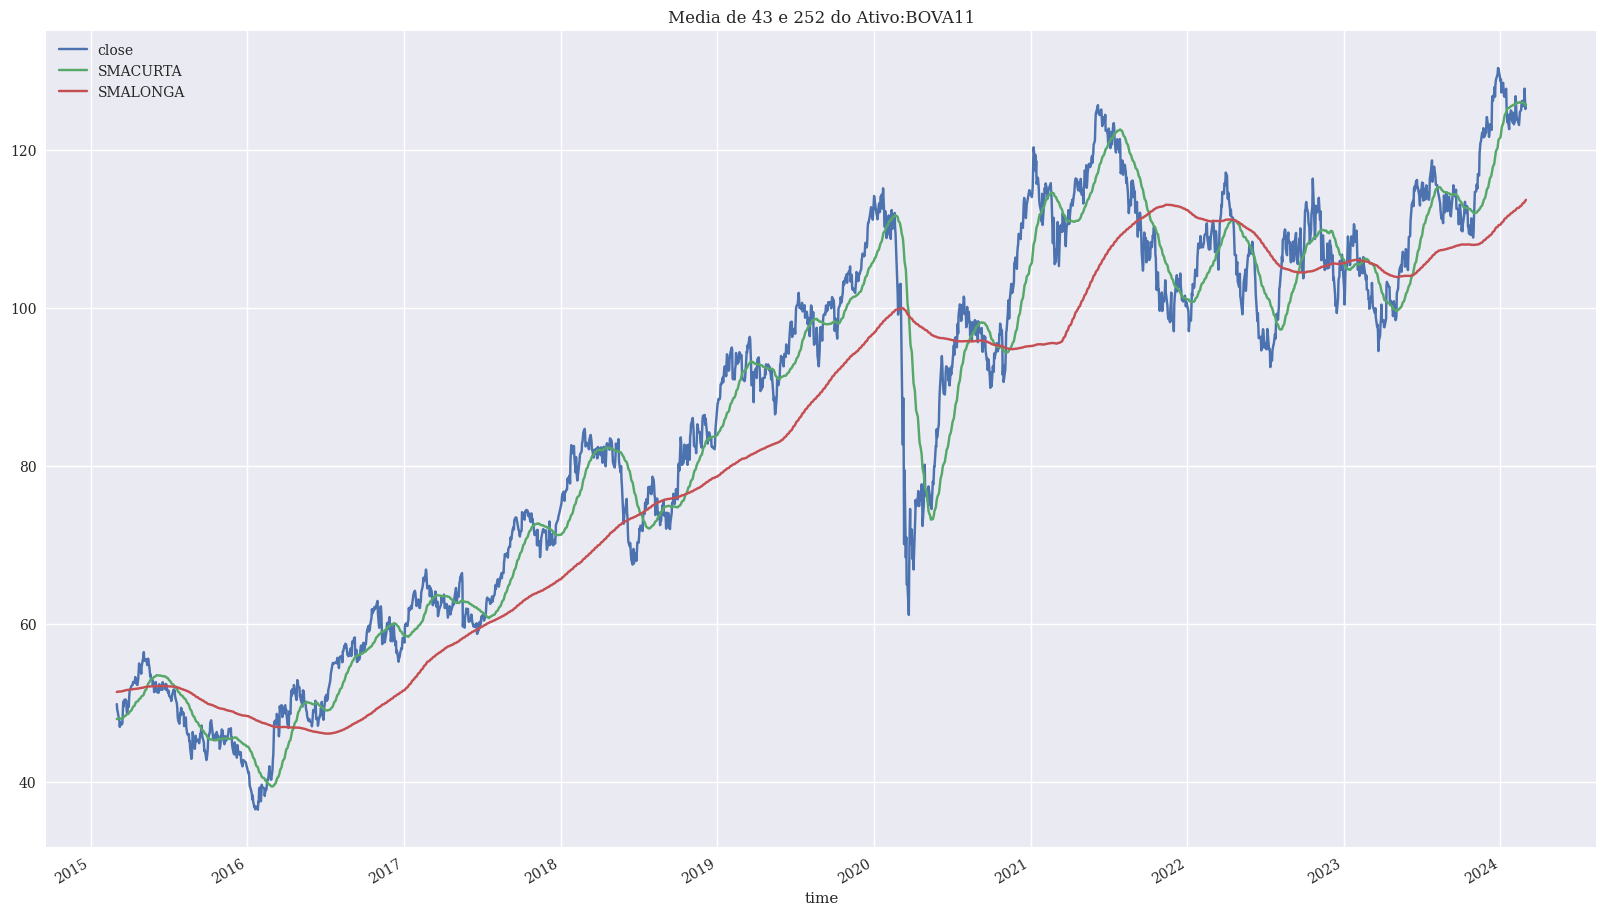

In [44]:
# plotando grafico 

data = data[['time', 'close', 'SMACURTA', 'SMALONGA']]

data = data.set_index('time')

data.plot(title = "Media de 43 e 252 do Ativo:"+ ativo, figsize = (20,12))

plt.show()

In [45]:
# criando regra de trade 

data['posicao'] = np.where(data['SMACURTA'] > data['SMALONGA'], 1,-1)

data['posicao'] = data['posicao']. shift(1)
data.dropna(inplace=True)

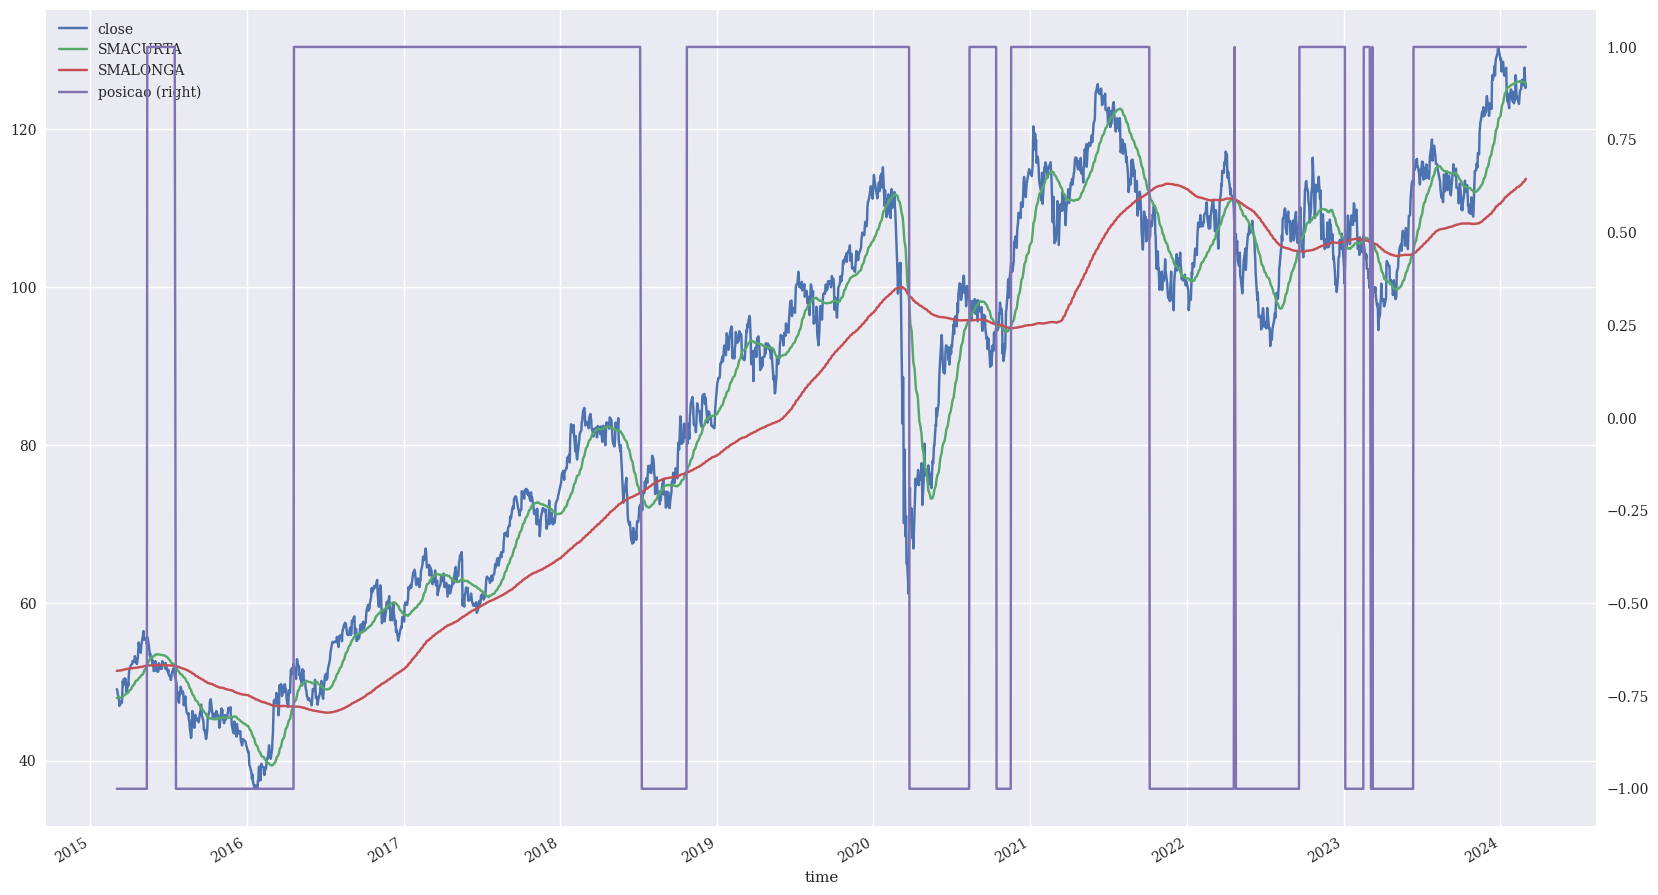

In [46]:
# plotando grafico 

data.plot(figsize = (20,12), secondary_y = 'posicao')
plt.show()

In [47]:
print(data)

             close    SMACURTA    SMALONGA  posicao
time                                               
2015-03-04   49.07   47.948605   51.388770     -1.0
2015-03-05   48.95   47.958140   51.402302     -1.0
2015-03-06   48.55   47.988140   51.414921     -1.0
2015-03-09   47.75   48.021395   51.419683     -1.0
2015-03-10   46.95   48.030000   51.423135     -1.0
...            ...         ...         ...      ...
2024-02-26  125.77  125.986512  113.390595      1.0
2024-02-27  127.84  125.974651  113.479008      1.0
2024-02-28  126.26  125.912326  113.568929      1.0
2024-02-29  125.25  125.810000  113.652659      1.0
2024-03-01  125.80  125.701628  113.745595      1.0

[2229 rows x 4 columns]


In [48]:
# fazendo calculos finaceiros 

data['retornos'] = np.log(data['close']/data['close'].shift(1))
data.dropna(inplace= True)

data['estrategia'] = data['posicao']*data['retornos']

retorno_simples = data[['retornos', 'estrategia']].sum()
retorno_log = data[['retornos', 'estrategia']].sum().apply(np.exp) - 1

print(retorno_log)
print(retorno_simples)

retornos      1.563685
estrategia   -0.623095
dtype: float64
retornos      0.941445
estrategia   -0.975761
dtype: float64


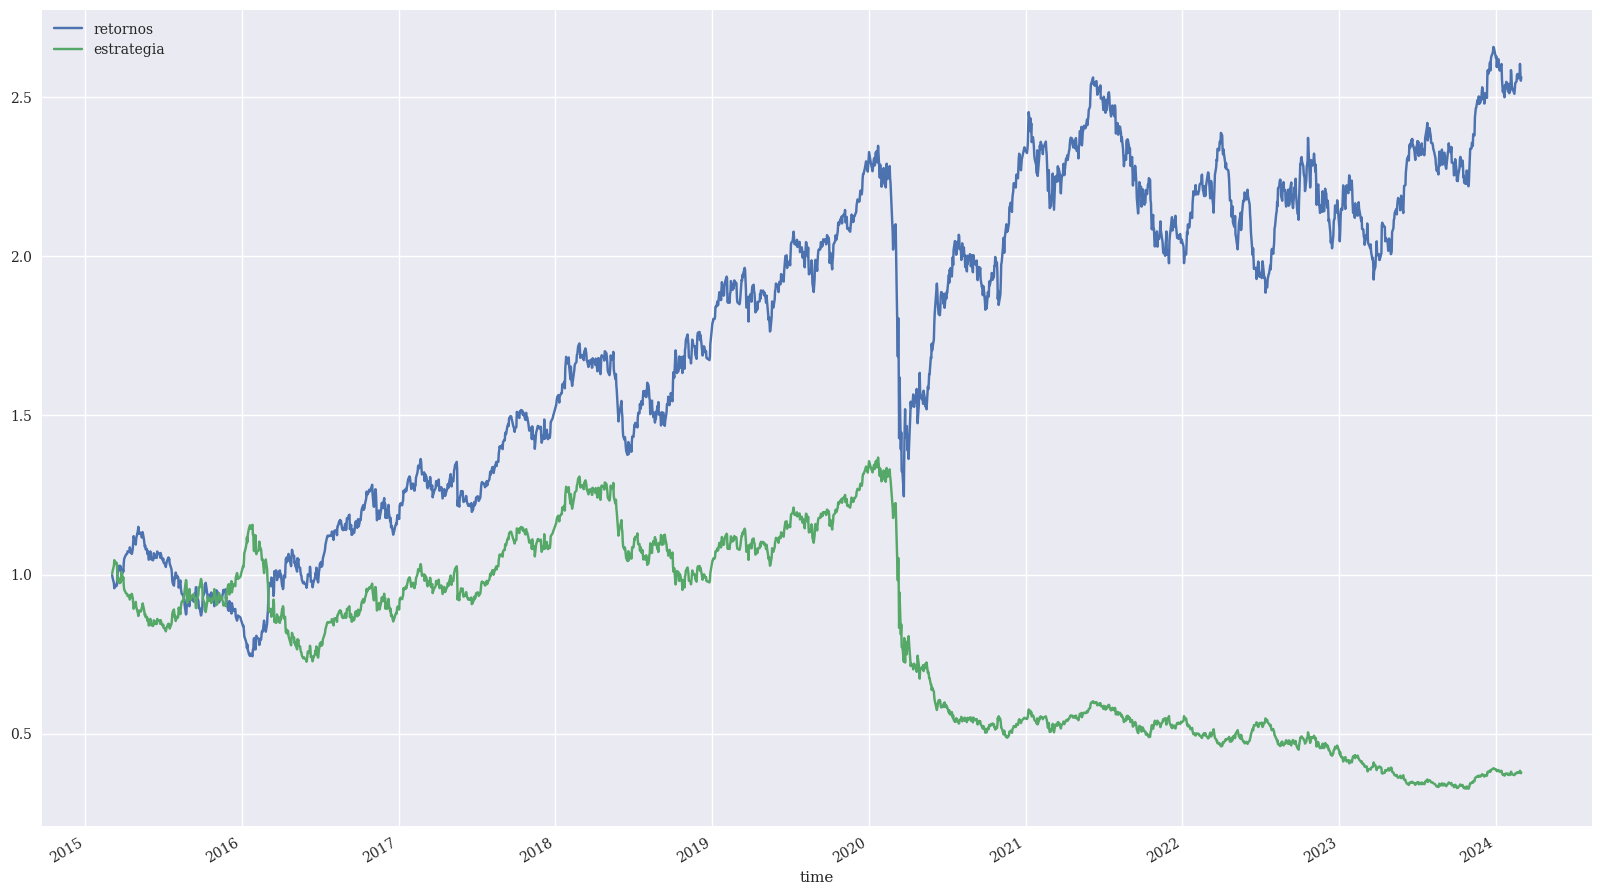

In [49]:
# grafico comparando estrategia posicion trade com estrategia 

data[['retornos', 'estrategia']]. cumsum().apply(np.exp). plot(figsize = (20,12))

plt.show()

In [50]:
# retorno acumulado 

data['retornoacululado'] = data['estrategia'].cumsum().apply(np.exp)
data['somamaxima'] = data['retornoacululado'].cummax()

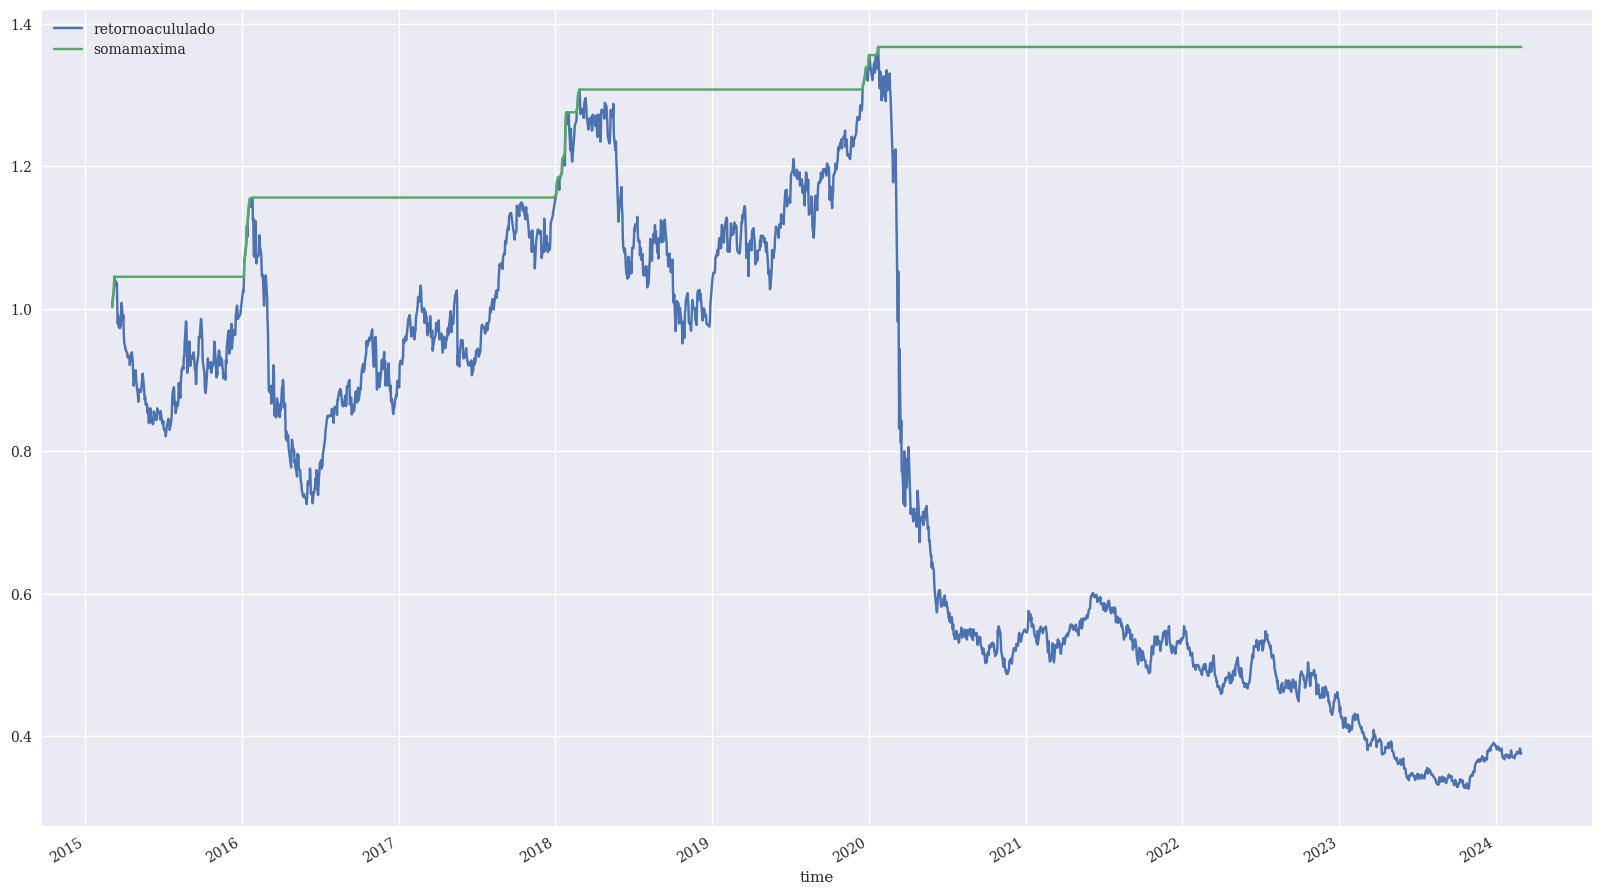

In [51]:
# plotando grafico etorno acumulado

data[['retornoacululado', 'somamaxima']].dropna().plot(figsize = (20,12))

plt.show()

In [52]:
# drawdown da estrategia 

drawdown = data['somamaxima'] - data['retornoacululado']

rebaixamento = drawdown.max()

print('rebaixamento:' + str(rebaixamento))

rebaixamento:1.0413098396364566


In [53]:
# Periodo que estrategia ficou positiva 

temp = drawdown[drawdown == 0]
print(temp)

time
2015-03-05    0.0
2015-03-06    0.0
2015-03-09    0.0
2015-03-10    0.0
2016-01-07    0.0
2016-01-08    0.0
2016-01-11    0.0
2016-01-12    0.0
2016-01-13    0.0
2016-01-15    0.0
2016-01-18    0.0
2016-01-20    0.0
2016-01-26    0.0
2018-01-02    0.0
2018-01-03    0.0
2018-01-04    0.0
2018-01-05    0.0
2018-01-08    0.0
2018-01-15    0.0
2018-01-17    0.0
2018-01-19    0.0
2018-01-22    0.0
2018-01-24    0.0
2018-01-26    0.0
2018-02-20    0.0
2018-02-21    0.0
2018-02-22    0.0
2018-02-23    0.0
2018-02-26    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-23    0.0
2019-12-26    0.0
2020-01-02    0.0
2020-01-20    0.0
2020-01-23    0.0
dtype: float64


In [54]:
# Periodo de tempo que estrategia ficou positiva 

periodos = (temp.index[1:].to_pydatetime() - temp.index[1:].to_pydatetime())

print(periodos.max())

0:00:00
